In [1]:
#Comments to run on Colab
#!apt-get -qq update; apt-get install -y python-dev libfftw3-dev libeigen3-dev ffmpeg pybind11-dev
#!pip install rmjarvis.eigency>=1.77.1
#!pip install galsim --no-cache-dir
#from google.colab import drive
#drive.mount('/content/drive')
#%cd drive/MyDrive/denoising
#!pip install scikit-image

import galsim
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%pylab inline

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from unets.unet import Unet

print(tf.test.gpu_device_name())

Populating the interactive namespace from numpy and matplotlib



In [4]:
dataset = np.load('datasets/dataset_45_64.npy',allow_pickle='TRUE').item()

im_train, im_val, target_train, target_val = train_test_split(dataset['VIGNETS_WITH_NOISE'], dataset['VIGNET_NOISELESS'],
                                                              test_size=0.2, random_state=10, shuffle=False, stratify=None)

im_train, target_train = shuffle(im_train, target_train)
#im_val, target_val = shuffle(im_val, target_val)

im_train = (tf.reshape(tf.convert_to_tensor(im_train), [36000, 64, 64, 1]))
target_train = tf.reshape(tf.convert_to_tensor(target_train), [36000, 64, 64, 1])
im_val = (tf.reshape(tf.convert_to_tensor(im_val), [9000, 64, 64, 1]))
target_val = tf.reshape(tf.convert_to_tensor(target_val), [9000, 64, 64, 1])

In [5]:
model=Unet(n_output_channels=1, kernel_size=3, layers_n_channels=[4, 8, 16, 32])
adam = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=adam, loss='mse')
history = model.fit(im_train, target_train, validation_data=(im_val, target_val), batch_size=10, 
           epochs=500, steps_per_epoch=200)
print(model.summary())

Epoch 1/500
 25/200 [==>...........................] - ETA: 16s - loss: 6.2521e-06

KeyboardInterrupt: 

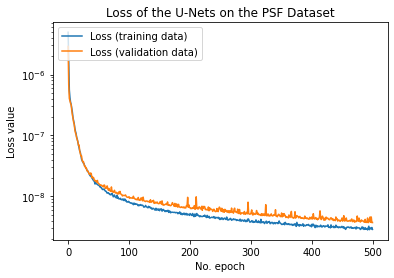

In [5]:
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss of the U-Nets on the PSF Dataset')
plt.ylabel('Loss value')
plt.yscale('log')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

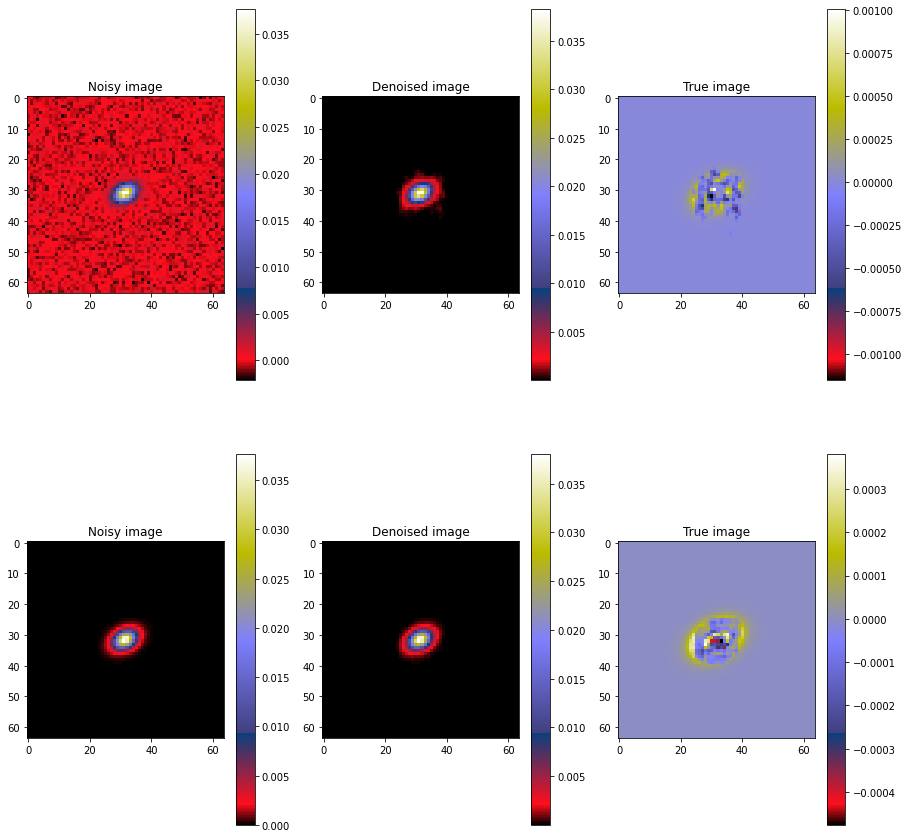

In [9]:
one_star_noiseless = tf.reshape(model.predict(im_val)[0,:,:], [64, 64])
one_star_truth = tf.reshape(tf.convert_to_tensor(target_val[0,:,:]), [64, 64])
one_star_noiseless = tf.cast(one_star_noiseless, one_star_truth.dtype)
one_star_noise = tf.reshape(tf.convert_to_tensor(im_val[0,:,:]), [64, 64])
second_star_noiseless = tf.reshape(model.predict(im_val)[19,:,:], [64, 64])
second_star_truth = tf.reshape(tf.convert_to_tensor(target_val[19,:,:]), [64, 64])
second_star_noiseless = tf.cast(second_star_noiseless, second_star_truth.dtype)
second_star_noise = tf.reshape(tf.convert_to_tensor(im_val[19,:,:]), [64, 64])



fig = plt.figure(num=0, figsize=(15,15))
plt.title('U-Nets Denoising')
subplot(231)
title('Noisy image')
imshow(one_star_noise, interpolation='None',cmap='gist_stern');colorbar()
subplot(232)
#imshow(one_star_noiseless-one_star_truth, interpolation='None',cmap='gist_stern');colorbar()
imshow(one_star_noiseless, interpolation='None',cmap='gist_stern');colorbar()
title('Denoised image')
subplot(233)
imshow(one_star_truth-one_star_noiseless, interpolation='None',cmap='gist_stern');colorbar()
title('True image')
subplot(234)
title('Noisy image')
imshow(second_star_noise, interpolation='None',cmap='gist_stern');colorbar()
subplot(235)
#imshow(second_star_noiseless-second_star_truth, interpolation='None',cmap='gist_stern');colorbar()
imshow(second_star_noiseless, interpolation='None',cmap='gist_stern');colorbar()
title('Denoised image')
subplot(236)
imshow(second_star_truth-second_star_noiseless, interpolation='None', cmap='gist_stern');colorbar()
title('True image')
show()


In [11]:
diff_e1_HSM = np.zeros(im_val.shape[0])
diff_e2_HSM = np.zeros(im_val.shape[0])
diff_R2_HSM = np.zeros(im_val.shape[0])
e1_HSM_measured = np.zeros(im_val.shape[0])
e2_HSM_measured = np.zeros(im_val.shape[0])
R2_HSM_measured = np.zeros(im_val.shape[0])
e1_HSM_true = np.zeros(im_val.shape[0])
e2_HSM_true = np.zeros(im_val.shape[0])
R2_HSM_true = np.zeros(im_val.shape[0])
predictions = model.predict(im_val)
for it in range(im_val.shape[0]):
  my_moments = galsim.hsm.FindAdaptiveMom(galsim.Image(np.reshape(predictions[it], (64,64))))
  diff_e1_HSM[it] = my_moments.observed_shape.g1-dataset['TRUE_E1_HSM'][36000+it]
  diff_e2_HSM[it] = my_moments.observed_shape.g2-dataset['TRUE_E2_HSM'][36000+it]
  diff_R2_HSM[it] = my_moments.moments_sigma-dataset['TRUE_R2_HSM'][36000+it]
  e1_HSM_measured[it] = my_moments.observed_shape.g1
  e2_HSM_measured[it] = my_moments.observed_shape.g2
  R2_HSM_measured[it] = my_moments.moments_sigma
  e1_HSM_true[it] = dataset['TRUE_E1_HSM'][36000+it]
  e2_HSM_true[it] = dataset['TRUE_E2_HSM'][36000+it]
  R2_HSM_true[it] = dataset['TRUE_R2_HSM'][36000+it]
  


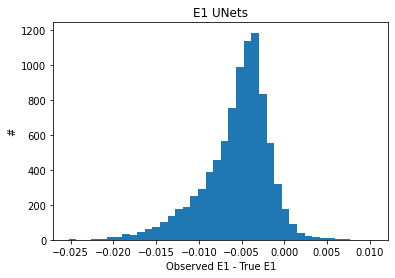

In [15]:
hist(diff_e1_HSM, bins=40)
pyplot.title('E1 UNets')
plt.ylabel("#")
plt.xlabel("Observed E1 - True E1")
plt.savefig("e1_unets.png")

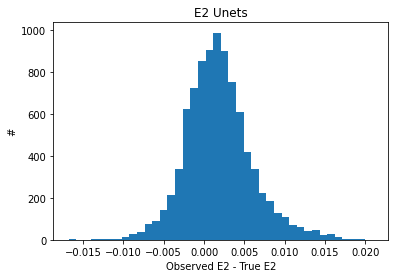

In [16]:
hist(diff_e2_HSM, bins=40)
pyplot.title('E2 Unets')
plt.ylabel("#")
plt.xlabel("Observed E2 - True E2")
plt.savefig("e2_unets.png")

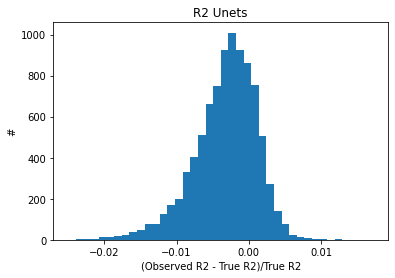

In [17]:
hist(-diff_R2_HSM/R2_HSM_true, bins=40)
pyplot.title('R2 Unets')
plt.ylabel("#")
plt.xlabel("(Observed R2 - True R2)/True R2")
plt.savefig("R2_unets.png")

In [18]:
from sklearn.metrics import mean_squared_error

print(mean_squared_error(e1_HSM_measured, e1_HSM_true, squared=False))
print(mean_squared_error(e2_HSM_measured, e2_HSM_true, squared=False))
print(mean_squared_error(R2_HSM_measured, R2_HSM_true, squared=False))

0.006821664501099155
0.00451082710261522
0.008081194967750331


In [19]:
print(mean(diff_e1_HSM))
print(mean(diff_e2_HSM))
print(mean(diff_R2_HSM))

-0.005588298175108224
0.001816309650784776
0.004804180065790812


In [6]:
model.save('Unets')

INFO:tensorflow:Assets written to: Unets/assets


INFO:tensorflow:Assets written to: Unets/assets
